# Data Preparation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit

pd.options.display.max_columns = 50
import warnings
warnings.filterwarnings("ignore")

In [2]:
from bs4 import BeautifulSoup as bs
import requests
import re
import time

In [3]:
df = pd.read_csv("../data/flight/training_dataset.csv")

In [4]:
df.head()

,id,number,airline,airline_name,scheduled_departure_time,scheduled_arrival_time,departure_airport_city,departure_airport_code,departure_airport_country,departure_airport_gate,departure_airport_name,departure_airport_region,departure_airport_terminal,departure_airport_timezone,arrival_airport_city,arrival_airport_code,arrival_airport_country,arrival_airport_gate,arrival_airport_name,arrival_airport_region,arrival_airport_terminal,arrival_airport_timezone,flight_equipment_iata,flight_equipment_name,flight_duration,delay
0,1,AK6430,AK,AirAsia,2018-10-05 22:00:00,2018-10-05 23:05:00,Kuala Lumpur,KUL,MY,J15,Kuala Lumpur International Airport,Asia,2,Asia/Kuala_Lumpur,Kota Bharu,KBR,MY,2,Sultan Ismail Petra Airport,Asia,NaN,Asia/Kuala_Lumpur,32S,Airbus A318 / A319 / A320 / A321,58m,2
1,2,ID*7164,ID*,Batik Air,2018-10-05 22:00:00,2018-10-05 23:55:00,Kuala Lumpur,KUL,MY,C33,Kuala Lumpur International Airport,Asia,M,Asia/Kuala_Lumpur,Jakarta,CGK,ID,5,Soekarno-Hatta International Airport,Asia,2,Asia/Jakarta,32S,Airbus A318 / A319 / A320 / A321,1h 55m,8
2,3,MXD9116,MXD,Malindo Air,2018-10-05 22:00:00,2018-10-05 23:55:00,Kuala Lumpur,KUL,MY,C33,Kuala Lumpur International Airport,Asia,M,Asia/Kuala_Lumpur,Jakarta,CGK,ID,5,Soekarno-Hatta International Airport,Asia,2,Asia/Jakarta,32S,Airbus A318 / A319 / A320 / A321,1h 55m,8
3,4,AK5198,AK,AirAsia,2018-10-05 22:05:00,2018-10-06 01:00:00,Kuala Lumpur,KUL,MY,J9,Kuala Lumpur International Airport,Asia,2,Asia/Kuala_Lumpur,Sandakan,SDK,MY,INT,Sandakan Airport,Asia,NaN,Asia/Kuala_Lumpur,32S,Airbus A318 / A319 / A320 / A321,2h 54m,0
4,5,AK516,AK,AirAsia,2018-10-05 22:10:00,2018-10-06 01:25:00,Kuala Lumpur,KUL,MY,P1,Kuala Lumpur International Airport,Asia,2,Asia/Kuala_Lumpur,Hanoi,HAN,VN,NaN,Noi Bai International Airport,Asia,T2,Asia/Ho_Chi_Minh,32S,Airbus A318 / A319 / A320 / A321,3h 17m,0


In [5]:
# gives some infos on columns types and number of null values
df_info = pd.DataFrame(df.dtypes).rename(columns={0:'data_type'})
df_info["#_unique"] = df.nunique()
df_info["#_nan"] = df.isnull().sum().astype(int)
df_info["%_nan"] = df.isnull().sum()/df.shape[0]*100

df_info.sort_values(by="#_unique", ascending=False)

,data_type,#_unique,#_nan,%_nan
id,int64,111068,0,0.000000
scheduled_arrival_time,object,14210,5,0.004502
scheduled_departure_time,object,12912,0,0.000000
number,object,2515,0,0.000000
flight_duration,object,693,0,0.000000
delay,int64,350,0,0.000000
arrival_airport_gate,object,267,98981,89.117478
departure_airport_gate,object,189,44209,39.803544
arrival_airport_code,object,154,0,0.000000
arrival_airport_name,object,154,0,0.000000


Looking at the DataFrame above we got these insights:
1. `scheduled_arrival_time` and `scheduled_departure_time` have to be converted into time format
2. `arrival_airport_gate`, `arrival_airport_terminal`, `departure_airport_gate`, `departure_airport_terminal` contain the most missing values, this can be caused by the fact that the passengers aren't tracked based on the gates and terminals. Percentages of their missing values are very high (would be nice if it can be dropped).
3. `flight_duration` is still in the object (string) type. It needs to be converted to `int`, in this case to minutes
4. `departure_airport_region`, `departure_airport_country` and `departure_airport_timezone` only contain 1 unique value, so we can safely drop them
5. We can also scrape the flight distance data from another website to get the distance between the two airports

## Feature Engineering

### Get Scheduled Flight Duration

#### Convert the time data to time objects

In [6]:
df["scheduled_departure_time"] = pd.to_datetime(df["scheduled_departure_time"]) 
df["scheduled_arrival_time"] = pd.to_datetime(df["scheduled_arrival_time"])

In [7]:
df["scheduled_flight_duration"] = df["scheduled_arrival_time"] - df["scheduled_departure_time"]
df["scheduled_flight_duration"] = df["scheduled_flight_duration"].dt.components['hours'] * 60 + df["scheduled_flight_duration"].dt.components['minutes']

In [8]:
df.head()

,id,number,airline,airline_name,scheduled_departure_time,scheduled_arrival_time,departure_airport_city,departure_airport_code,departure_airport_country,departure_airport_gate,departure_airport_name,departure_airport_region,departure_airport_terminal,departure_airport_timezone,arrival_airport_city,arrival_airport_code,arrival_airport_country,arrival_airport_gate,arrival_airport_name,arrival_airport_region,arrival_airport_terminal,arrival_airport_timezone,flight_equipment_iata,flight_equipment_name,flight_duration,delay,scheduled_flight_duration
0,1,AK6430,AK,AirAsia,2018-10-05 22:00:00,2018-10-05 23:05:00,Kuala Lumpur,KUL,MY,J15,Kuala Lumpur International Airport,Asia,2,Asia/Kuala_Lumpur,Kota Bharu,KBR,MY,2,Sultan Ismail Petra Airport,Asia,NaN,Asia/Kuala_Lumpur,32S,Airbus A318 / A319 / A320 / A321,58m,2,65.0
1,2,ID*7164,ID*,Batik Air,2018-10-05 22:00:00,2018-10-05 23:55:00,Kuala Lumpur,KUL,MY,C33,Kuala Lumpur International Airport,Asia,M,Asia/Kuala_Lumpur,Jakarta,CGK,ID,5,Soekarno-Hatta International Airport,Asia,2,Asia/Jakarta,32S,Airbus A318 / A319 / A320 / A321,1h 55m,8,115.0
2,3,MXD9116,MXD,Malindo Air,2018-10-05 22:00:00,2018-10-05 23:55:00,Kuala Lumpur,KUL,MY,C33,Kuala Lumpur International Airport,Asia,M,Asia/Kuala_Lumpur,Jakarta,CGK,ID,5,Soekarno-Hatta International Airport,Asia,2,Asia/Jakarta,32S,Airbus A318 / A319 / A320 / A321,1h 55m,8,115.0
3,4,AK5198,AK,AirAsia,2018-10-05 22:05:00,2018-10-06 01:00:00,Kuala Lumpur,KUL,MY,J9,Kuala Lumpur International Airport,Asia,2,Asia/Kuala_Lumpur,Sandakan,SDK,MY,INT,Sandakan Airport,Asia,NaN,Asia/Kuala_Lumpur,32S,Airbus A318 / A319 / A320 / A321,2h 54m,0,175.0
4,5,AK516,AK,AirAsia,2018-10-05 22:10:00,2018-10-06 01:25:00,Kuala Lumpur,KUL,MY,P1,Kuala Lumpur International Airport,Asia,2,Asia/Kuala_Lumpur,Hanoi,HAN,VN,NaN,Noi Bai International Airport,Asia,T2,Asia/Ho_Chi_Minh,32S,Airbus A318 / A319 / A320 / A321,3h 17m,0,195.0


### Get Distance Between Two Airports

#### Get the Unique Route

In [9]:
route_df = df.drop_duplicates(subset=["departure_airport_code", "arrival_airport_code"])[["departure_airport_code", "arrival_airport_code"]]
route_df.head()

,departure_airport_code,arrival_airport_code
0,KUL,KBR
1,KUL,CGK
3,KUL,SDK
4,KUL,HAN
5,KUL,AOR


Basically what the below codes do is scraping the distance (in km) from prokerala.com using the dataframe of the unique route of the airplane.

In [10]:
# flight_distances = []

# for route in route_df.values:
#     doc = f"https://www.prokerala.com/travel/airports/distance/from-{route[0].lower()}/to-{route[1].lower()}/"

#     response = requests.get(doc, timeout = 10)
#     soup = bs(response.content, "html.parser")

#     content = [element.text for element in soup.find_all('div', {'class': 'tc'})]
    
#     if content:
#         flight_distance_content = content[1]

#         flight_distance = re.findall(r"(\d+(\.\d+)?)", content[1])[1][0]
#         print(flight_distance)
#         flight_distances.append(float(flight_distance))
        
#     else:
#         flight_distances.append(np.nan)
    
#     time.sleep(2)

#### Set the Value and Save it for Later Use

In [11]:
# route_df["distance"] = flight_distances

# route_df.to_csv("route_distance", index=False)

In [12]:
route_df = pd.read_csv("route_distance")

In [13]:
df = pd.merge(df, route_df,  how='left', left_on=["departure_airport_code", "arrival_airport_code"], right_on=["departure_airport_code", "arrival_airport_code"])

### Get the Day

In [14]:
df["scheduled_departure_day"] = df["scheduled_departure_time"].apply(lambda x: x.strftime("%A"))

### Flag Weekend

In [15]:
df["scheduled_departure_weekend_flag"] = df["scheduled_departure_day"].apply(lambda x: 1 if x in ["Sunday", "Saturday"] else 0)

### Get the Hour

In [16]:
df["scheduled_departure_hour"] = df["scheduled_departure_time"].apply(lambda x : x.hour)

### Get the Parts of the Day

https://7esl.com/times-of-the-day/

In [17]:
def convert_to_pod(hour):
    if hour <= 4:
        return'Late Night'
    elif hour <= 8:
        return 'Early Morning'
    elif hour <= 12:
        return 'Morning'
    elif hour <= 16:
        return'Noon'
    elif hour <= 20:
        return 'Eve'
    else:
        return'Night'

In [18]:
df["scheduled_departure_pod"] = df["scheduled_departure_hour"].apply(convert_to_pod)

### Flag Holiday

In [19]:
holiday_df = pd.read_csv("../data/flight/holiday_2018.csv")

In [20]:
holiday_df["Date"] = holiday_df["Date"].str.split("-").apply(lambda x: f"{x[2]}-{x[1]}-{x[0]}")

In [21]:
df["scheduled_departure_date"] = df["scheduled_departure_time"].apply(lambda x: x.strftime("%Y-%m-%d"))

holidays_2018 = list(holiday_df["Date"])

df["scheduled_departure_holiday_flag"] = df["scheduled_departure_date"].apply(lambda x: 1 if x in holidays_2018 else 0)

### Flag -1 Holiday

In [22]:
holidays_2018_1 = []
for holiday_2018 in holidays_2018:
    if holiday_2018[5:7] in ["10", "11"]:
        day_before = int(holiday_2018[-2:]) - 1
        day_after = int(holiday_2018[-2:]) + 1
        
        if day_before // 10 == 0:
            day_before = f"0{day_before}"
        
        if day_after // 10 == 0:
            day_after = f"0{day_after}"
        
        date_before = f"2018-{holiday_2018[5:7]}-{day_before}"
        date_after = f"2018-{holiday_2018[ 5:7]}-{day_after}"
        
        holidays_2018_1.append(date_before) 
        holidays_2018_1.append(date_after)

In [23]:
df["scheduled_departure_min_1_holiday_flag"] = df["scheduled_departure_date"].apply(lambda x: 1 if x in holidays_2018_1 else 0)

### Flag Delay

In [24]:
df["flag_delay"] = df["delay"].apply(lambda x : 1 if x > 0 else 0)

## Data Cleaning

### Drop Possibly Unused Features

The feature below are dropped based on these criteria:
1. Categorical features which have plenty number of unique values (e.g. `scheduled_arrival_time`)
2. Categorical features with similar number of unique values (e.g. `arrival_airport_name` and `arrival_airport_code` are pretty similar, one of them needs to be dropped)
3. Features which have more than ~40% of missing data
4. Features with only 1 unique value


In [25]:
df = df.drop([
    "id", 
    "scheduled_arrival_time", 
    "scheduled_departure_time", 
    "flight_duration",
    "arrival_airport_gate",
    "departure_airport_gate",
    "arrival_airport_name",
    "arrival_airport_city",
    "airline",
    "flight_equipment_name",
    "arrival_airport_timezone",
    "arrival_airport_country",
    "arrival_airport_terminal",
    "departure_airport_name",
    "departure_airport_city",
    "departure_airport_terminal",
    "arrival_airport_region",
    "departure_airport_region",
    "departure_airport_country",
    "departure_airport_timezone"
], axis=1)

In [26]:
df.head()

,number,airline_name,departure_airport_code,arrival_airport_code,flight_equipment_iata,delay,scheduled_flight_duration,distance,scheduled_departure_day,scheduled_departure_weekend_flag,scheduled_departure_hour,scheduled_departure_pod,scheduled_departure_date,scheduled_departure_holiday_flag,scheduled_departure_min_1_holiday_flag,flag_delay
0,AK6430,AirAsia,KUL,KBR,32S,2,65.0,385.98,Friday,0,22,Night,2018-10-05,0,1,1
1,ID*7164,Batik Air,KUL,CGK,32S,8,115.0,1129.47,Friday,0,22,Night,2018-10-05,0,1,1
2,MXD9116,Malindo Air,KUL,CGK,32S,8,115.0,1129.47,Friday,0,22,Night,2018-10-05,0,1,1
3,AK5198,AirAsia,KUL,SDK,32S,0,175.0,1846.94,Friday,0,22,Night,2018-10-05,0,1,0
4,AK516,AirAsia,KUL,HAN,32S,0,195.0,2102.37,Friday,0,22,Night,2018-10-05,0,1,0


In [27]:
delay_by_features = ["airline_name", 
                     "scheduled_departure_pod", 
                     "scheduled_departure_hour", 
                     "scheduled_departure_holiday_flag", 
                     "scheduled_departure_day",
                    "arrival_airport_code",
                     "departure_airport_code",
                    "number"]
delay_bys = {}

for delay_by_feature in delay_by_features:
    cnt_delay_by_df = df.groupby(delay_by_feature).sum()["flag_delay"].reset_index().rename(columns={"flag_delay": "cnt_delay"})
    obs_delay_by_df = df.groupby(delay_by_feature).count()["flag_delay"].reset_index().rename(columns={"flag_delay": "obs_delay"})

    delay_by_df = pd.merge(cnt_delay_by_df, obs_delay_by_df,  how='left', left_on=[delay_by_feature], right_on=[delay_by_feature])
    delay_by_df["%_delay"] = delay_by_df["cnt_delay"] / delay_by_df["obs_delay"]
    
    delay_bys[delay_by_feature] = delay_by_df.sort_values(by="%_delay")

In [68]:
len(delay_bys)

8

In [51]:
labels = list(delay_bys["scheduled_departure_pod"]["scheduled_departure_pod"])
sizes = list(round(delay_bys["scheduled_departure_pod"]["%_delay"] * 100))

In [75]:
fig.axes[0].plot(x, y)
plt.show()

TEST
TEST
TEST
TEST
TEST
TEST
TEST
TEST


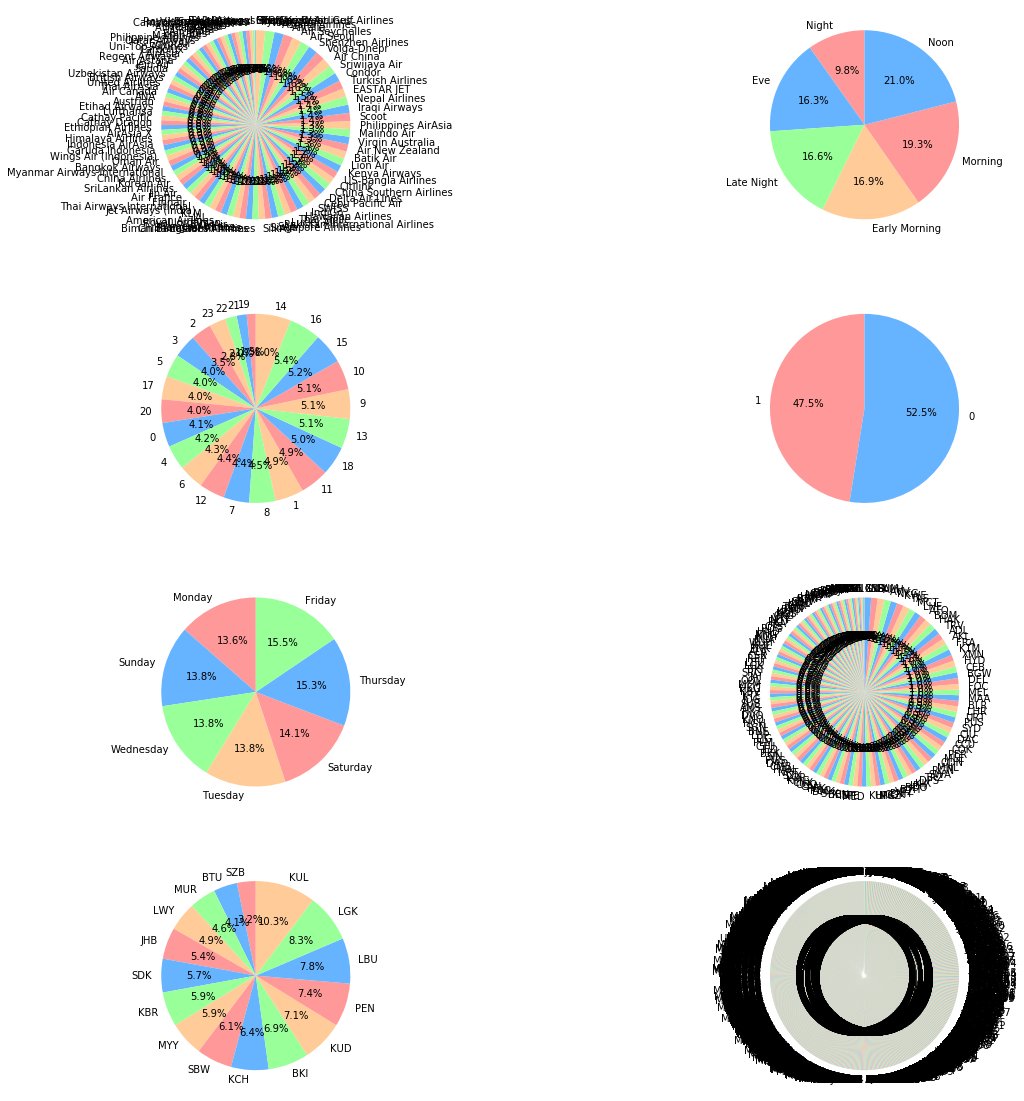

In [82]:
fig, axs = plt.subplots(len(delay_bys)//2, 2, figsize=(20, 20))

i, j = 0, 0
for col in delay_bys.keys():
    print(f"{i},{j}")
    labels = list(delay_bys[col][col])
    sizes = list(round(delay_bys[col]["%_delay"] * 100))
    axs[0, 0].set_title('Axis [0,0]')
    axs[i, j].pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
    j += 1
    
    if j % 2 == 0:
        j = 0
        i += 1
        
    
    

# axs[0, 0].pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
# axs[0, 0].set_title('Axis [0,0]')
# axs[0, 1].plot(x, y, 'tab:orange')
# axs[0, 1].set_title('Axis [0,1]')
# axs[1, 0].plot(x, -y, 'tab:green')
# axs[1, 0].set_title('Axis [1,0]')
# axs[1, 1].plot(x, -y, 'tab:red')
# axs[1, 1].set_title('Axis [1,1]')

# for ax in axs.flat:
#     ax.set(xlabel='x-label', ylabel='y-label')

# for ax in axs.flat:
#     ax.label_outer()

# for i, ax in enumerate(fig.axes):
#     if i < 3:
#         print(ax)
#         plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, ax=ax)
#         ax.set_title("OwO".replace("%", " ").upper()) 
plt.show()

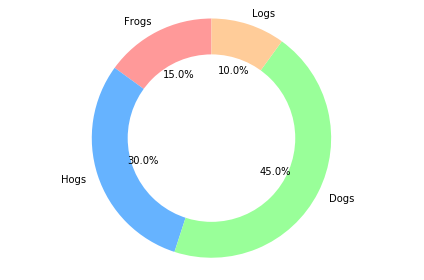

In [40]:
import matplotlib.pyplot as plt
# Pie chart
labels = ['Frogs', 'Hogs', 'Dogs', 'Logs']
sizes = [15, 30, 45, 10]
#colors
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

In [29]:
cnt_delay_by_airline_df = df.groupby("scheduled_departure_hour").sum()["flag_delay"].reset_index().rename(columns={"flag_delay": "cnt_delay"})
obs_delay_by_airline_df = df.groupby("scheduled_departure_hour").count()["flag_delay"].reset_index().rename(columns={"flag_delay": "obs_delay"})

delay_by_airline_df = pd.merge(cnt_delay_by_airline_df, obs_delay_by_airline_df,  how='left', left_on=["scheduled_departure_hour"], right_on=["scheduled_departure_hour"])
delay_by_airline_df["%_delay"] = delay_by_airline_df["cnt_delay"] / delay_by_airline_df["obs_delay"]

delay_by_airline_df.sort_values(by="%_delay").head()

,scheduled_departure_hour,cnt_delay,obs_delay,%_delay
19,19,12,68,0.176471
21,21,82,405,0.202469
22,22,1084,4691,0.231081
23,23,1933,5775,0.334719
2,2,2704,6521,0.414660


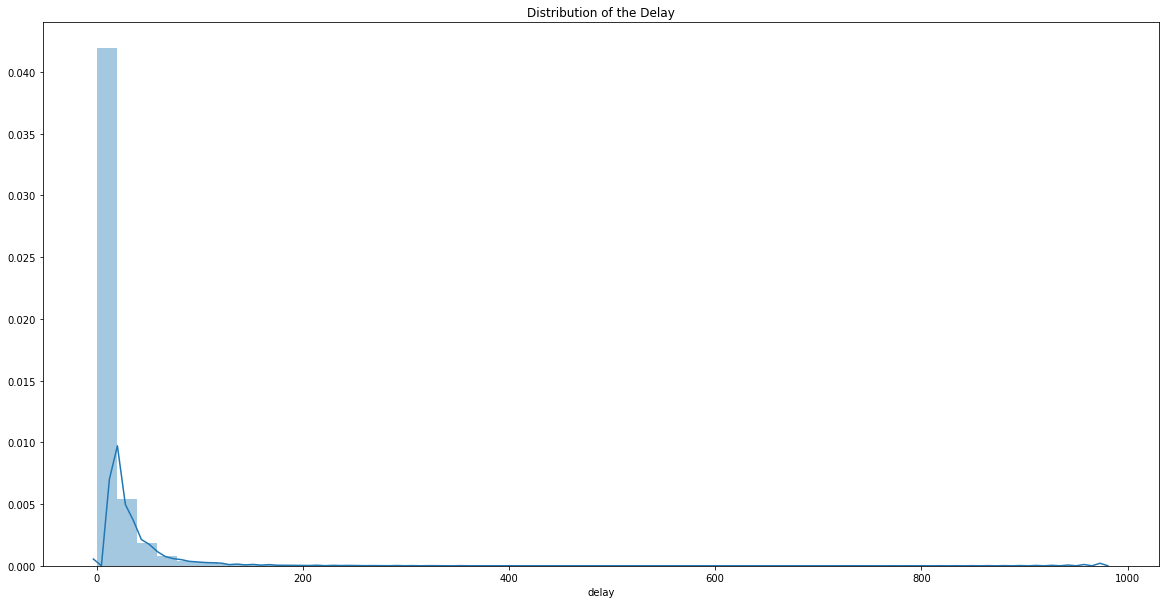

In [30]:
plt.figure(figsize=[20, 10])
sns.distplot(df["delay"])
plt.title("Distribution of the Delay")
plt.show()

In [31]:
print(f"The total number of rows before the deletion of the outliers based on the column delay is {df.shape[0]}")

The total number of rows before the deletion of the outliers based on the column delay is 111068


In [32]:
q1 = df["delay"].quantile(0.25)
q3 = df["delay"].quantile(0.75)

iqr = q3 - q1

In [33]:
df = df[~(df["delay"] > (q3 + 1.5 * iqr))]

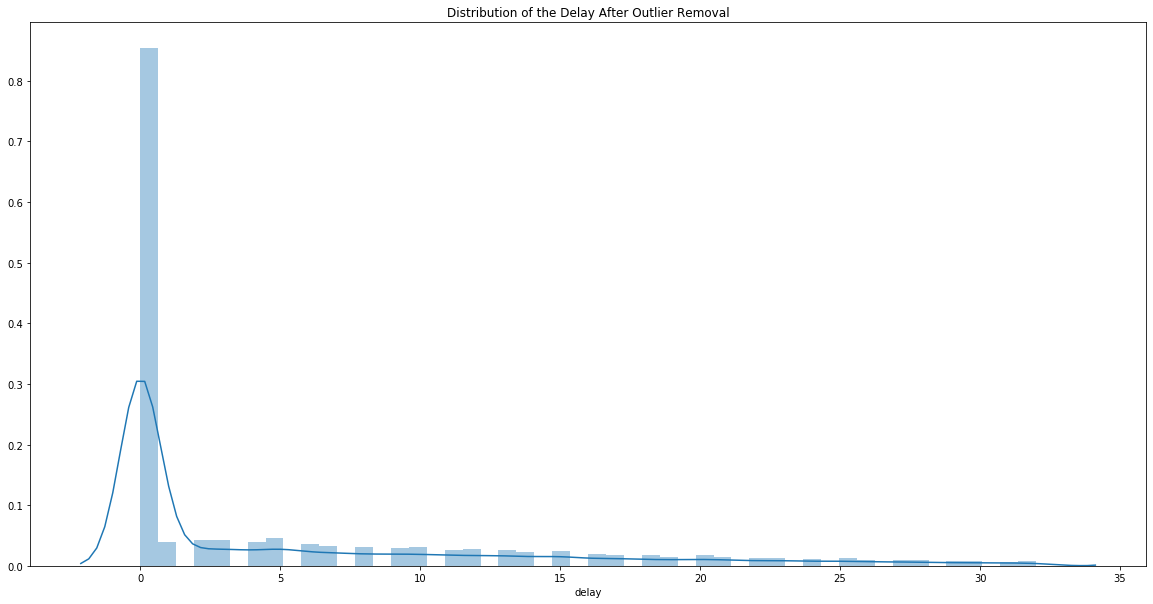

In [34]:
plt.figure(figsize=[20, 10])
sns.distplot(df["delay"])
plt.title("Distribution of the Delay After Outlier Removal")
plt.show()

In [35]:
print(f"The total number of rows before the deletion of the outliers based on the column delay is {df.shape[0]}")

The total number of rows before the deletion of the outliers based on the column delay is 100209


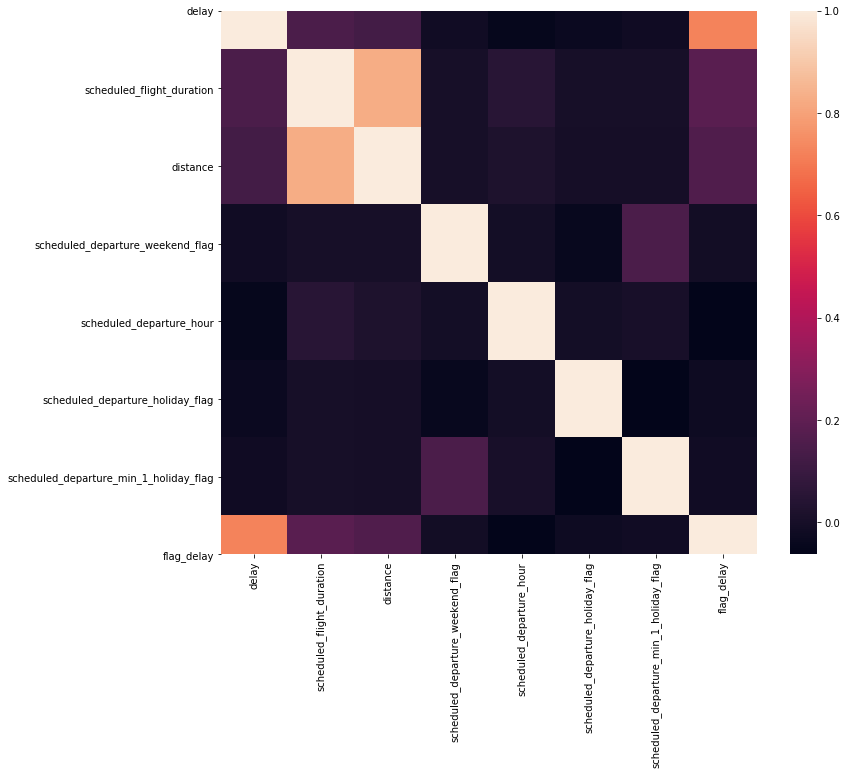

In [36]:
plt.figure(figsize=[12, 10])
sns.heatmap(df.corr())
plt.show()

## Linear Regression